In [5]:
!pip install opencv-python

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import scipy
import cv2

import keras

Using TensorFlow backend.
C:\Users\pvbha\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pvbha\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pvbha\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pvbha\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [7]:
import random

In [16]:
train_data = pd.read_csv('C:\\Users\\pvbha\\Internship\\aerial-cactus-identification\\train.csv',encoding = "ISO-8859-1")

In [17]:
train_data.shape

(17500, 2)

In [18]:
train_data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [19]:
train_data.has_cactus.unique()

array([1, 0], dtype=int64)

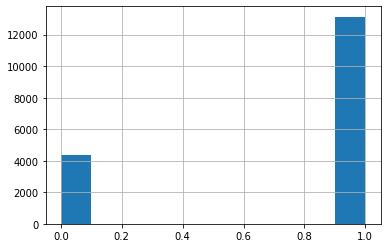

In [20]:
train_data.has_cactus.hist()

In [21]:
train_data.has_cactus.value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

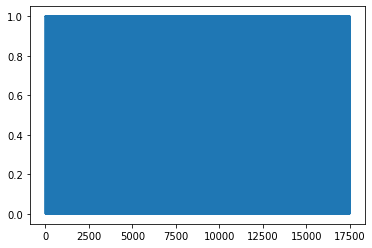

In [22]:
train_data.has_cactus.plot()

In [36]:
def image_generator2(batch_size = 16, all_data=True, shuffle=True, train=True, indexes=None):
    while True:
        if indexes is None:
            if train:
                if all_data:
                    indexes = np.arange(train_data.shape[0])
                else:
                    indexes = np.arange(train_data[:15000].shape[0])
                if shuffle:
                    np.random.shuffle(indexes)
            else:
                indexes = np.arange(train_data[15000:].shape[0])
            
        N = int(len(indexes) / batch_size)
       

        # Read in each input, perform preprocessing and get labels
        for i in range(N):
            current_indexes = indexes[i*batch_size: (i+1)*batch_size]
            batch_input = []
            batch_output = [] 
            for index in current_indexes:
                img = mpimg.imread('C:\\Users\\pvbha\\Internship\\aerial-cactus-identification\\train\\train\\' + train_data.id[index])
                batch_input += [img]
                batch_input += [img[::-1, :, :]]
                batch_input += [img[:, ::-1, :]]
                batch_input += [np.rot90(img)]
                
                temp_img = np.zeros_like(img)
                temp_img[:28, :, :] = img[4:, :, :]
                batch_input += [temp_img]
                
                temp_img = np.zeros_like(img)
                temp_img[:, :28, :] = img[:, 4:, :]
                batch_input += [temp_img]
                
                temp_img = np.zeros_like(img)
                temp_img[4:, :, :] = img[:28, :, :]
                batch_input += [temp_img]
                
                temp_img = np.zeros_like(img)
                temp_img[:, 4:, :] = img[:, :28, :]
                batch_input += [temp_img]
                
                batch_input += [cv2.resize(img[2:30, 2:30, :], (32, 32))]
                
                batch_input += [scipy.ndimage.interpolation.rotate(img, 10, reshape=False)]
                
                batch_input += [scipy.ndimage.interpolation.rotate(img, 5, reshape=False)]
                
                
                for _ in range(11):
                    batch_output += [train_data.has_cactus[index]]
                
            batch_input = np.array( batch_input )
            batch_output = np.array( batch_output )
        
            yield( batch_input, batch_output.reshape(-1, 1) )

In [37]:
positive_examples = train_data[train_data.has_cactus==1]
negative_examples = train_data[train_data.has_cactus==0]

In [38]:
def augment_img(img):
    batch_input = []
    batch_input += [img]
    batch_input += [img[::-1, :, :]]
    batch_input += [img[:, ::-1, :]]
    batch_input += [np.rot90(img)]
                
    temp_img = np.zeros_like(img)
    temp_img[:28, :, :] = img[4:, :, :]
    batch_input += [temp_img]
                
    temp_img = np.zeros_like(img)
    temp_img[:, :28, :] = img[:, 4:, :]
    batch_input += [temp_img]
                
    temp_img = np.zeros_like(img)
    temp_img[4:, :, :] = img[:28, :, :]
    batch_input += [temp_img]
                
    temp_img = np.zeros_like(img)
    temp_img[:, 4:, :] = img[:, :28, :]
    batch_input += [temp_img]
                
    batch_input += [cv2.resize(img[2:30, 2:30, :], (32, 32))]
                
    batch_input += [scipy.ndimage.interpolation.rotate(img, 10, reshape=False)]
                
    batch_input += [scipy.ndimage.interpolation.rotate(img, 5, reshape=False)]
    
    return batch_input

In [39]:
def image_generator(batch_size = 8, all_data=True, shuffle=True, train=True, indexes=None):
    while True:
        if indexes is None:
            if train:
                indexes = positive_examples.index.tolist()
                neg_indexes = negative_examples.index.tolist()
                if shuffle:
                    np.random.shuffle(indexes)
                    np.random.shuffle(neg_indexes)
            
        N = int(len(indexes) / (batch_size/2))
        neg_N = int(len(neg_indexes) / (batch_size/2))
       
        j = 0

        # Read in each input, perform preprocessing and get labels
        for i in range(N):
            current_indexes = indexes[i*(batch_size//2): (i+1)*(batch_size//2)]
            current_neg_indexes = neg_indexes[j*(batch_size//2): (j+1)*(batch_size//2)]
            j = (j + 1) % neg_N
            batch_input = []
            batch_output = [] 
            for ind in range(len(current_indexes)):
                index = current_indexes[ind]
                neg_index = current_neg_indexes[ind]
                
                img = mpimg.imread('C:\\Users\\pvbha\\Internship\\aerial-cactus-identification\\train\\train\\' + train_data.id[index])
                batch_input.extend(augment_img(img))
                for _ in range(11):
                    batch_output += [train_data.has_cactus[index]]
                
                neg_img = mpimg.imread('C:\\Users\\pvbha\\Internship\\aerial-cactus-identification\\train\\train\\' + train_data.id[neg_index])
                batch_input.extend(augment_img(neg_img))
                for _ in range(11):
                    batch_output += [train_data.has_cactus[neg_index]]
                
#                 factor = 0.05
#                 new_img = factor*neg_img + (1-factor)*img
#                 batch_input.append(new_img)
#                 batch_output += [factor*train_data.has_cactus[neg_index]+(1-factor)*train_data.has_cactus[index]]
                
#                 factor = 0.95
#                 new_img = factor*neg_img + (1-factor)*img
#                 batch_input.append(new_img)
#                 batch_output += [factor*train_data.has_cactus[neg_index]+(1-factor)*train_data.has_cactus[index]]
            
                
                
            batch_input = np.array( batch_input )
            batch_output = np.array( batch_output )
        
            yield( batch_input, batch_output.reshape(-1, 1) )


In [40]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (5, 5), input_shape=(32, 32, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(64, (5, 5)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(128, (5, 5)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(128, (5, 5)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(256, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(256, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(512, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Flatten())


model.add(keras.layers.Dense(100))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Dense(1, activation='sigmoid'))

In [41]:
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return keras.callbacks.LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=2)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.fit_generator(image_generator(), steps_per_epoch= train_data.shape[0] / 8, epochs=30, callbacks=[lr_sched, early_stop])

Epoch 1/30
1505/2187 [===================>..........] - ETA: 48:35 - loss: 0.1155 - accuracy: 0.9572

In [ ]:
model.evaluate_generator(image_generator2(), steps=train_data.shape[0]//16)